<a href="https://colab.research.google.com/github/nadeem785/Dog_vision/blob/main/ball_Game_finder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !unzip "/content/drive/MyDrive/Ball_Game/balls_datasets_cnn.zip" -d "/content/drive/MyDrive/Ball_Game"

In [8]:
import os
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import tf_keras as keras

In [2]:
len(os.listdir("/content/drive/MyDrive/Ball_Game/train"))

15

In [3]:
len(os.listdir("/content/drive/MyDrive/Ball_Game/test"))

15

In [4]:
Num_Sample= 1000 #@param {type:'slider',min:1000,max:5000,step:1000}

In [32]:
unique_labels= [val for val in os.listdir("/content/drive/MyDrive/Ball_Game/train")]

In [6]:
unique_labels
filenames= [os.path.join("/content/drive/MyDrive/Ball_Game/train/",folder,file)
for folder in  os.listdir("/content/drive/MyDrive/Ball_Game/train")
for file in os.listdir(os.path.join("/content/drive/MyDrive/Ball_Game/train/",folder))

            ]


In [7]:
from  IPython.display  import Image

In [8]:
boolean_labels=[[val== unique_labels for val in  os.path.basename(os.path.dirname(fname))] for fname in filenames]

In [9]:

# Get label from each path
labels_val = [os.path.basename(os.path.dirname(fname)) for fname in filenames]

# One-hot boolean labels
boolean_labels = [[label == cls for cls in unique_labels] for label in labels_val]
x=np.array(filenames)
y=np.array(boolean_labels)
x_train,x_val,y_train,y_val=train_test_split(x[:Num_Sample],y[:Num_Sample],test_size=0.3,random_state=42)


In [18]:
#creating function to encode images in tensors and  labels in desired formate
def preprocess(image_path):
  image= tf.io.read_file(image_path)
  image= tf.image.decode_jpeg(image,channels=3)
  image= tf.image.convert_image_dtype(image,tf.float32)
  image= tf.image.resize(image,[ 224 ,224])

  return image
#now for data which has the labels
def preprocess_with_label(image_path,label):
  return (preprocess(image_path),label)


In [19]:

#now creating the batches so that the model can easily get trained
Batch_size=32

def create_batches(x,y=None, batch_size=Batch_size,test_data=False,valid_data=False):

  #for test data we dont need to shuffle
  if test_data:
    print("creating_test_data, bathces")
    data= tf.data.Dataset.from_tensor_slices(tf.constant(x))
    data_batches= data.map(preprocess).batch(batch_size)
    return data_batches
  elif valid_data:
    print("creating_validation_data, bathces")
    data= tf.data.Dataset.from_tensor_slices((tf.constant(x),tf.constant(y)))
    data_batches= data.map(preprocess_with_label).batch(batch_size)
    return data_batches
  else:
    print("creating_training_data, bathces")
    data= tf.data.Dataset.from_tensor_slices((tf.constant(x),tf.constant(y)))
    data= data.shuffle(buffer_size=len(x))
    data_batches= data.map(preprocess_with_label).batch(batch_size)
    return data_batches


In [12]:
#lets create batches
train_data= create_batches(x_train,y_train)
val_data= create_batches(x_val,y_val,valid_data=True)

creating_training_data, bathces
creating_validation_data, bathces


In [13]:
#lets visualize the data we created in batches
def visualize_data(image, label):
  plt.figure(figsize=(10,10))
  for i in range(0,25):
    ax= plt.subplot(5,5,i+1)
    plt.imshow(image[i])
    plt.title(unique_labels[(np.argmax(label[i]))])
    plt.axis("off")




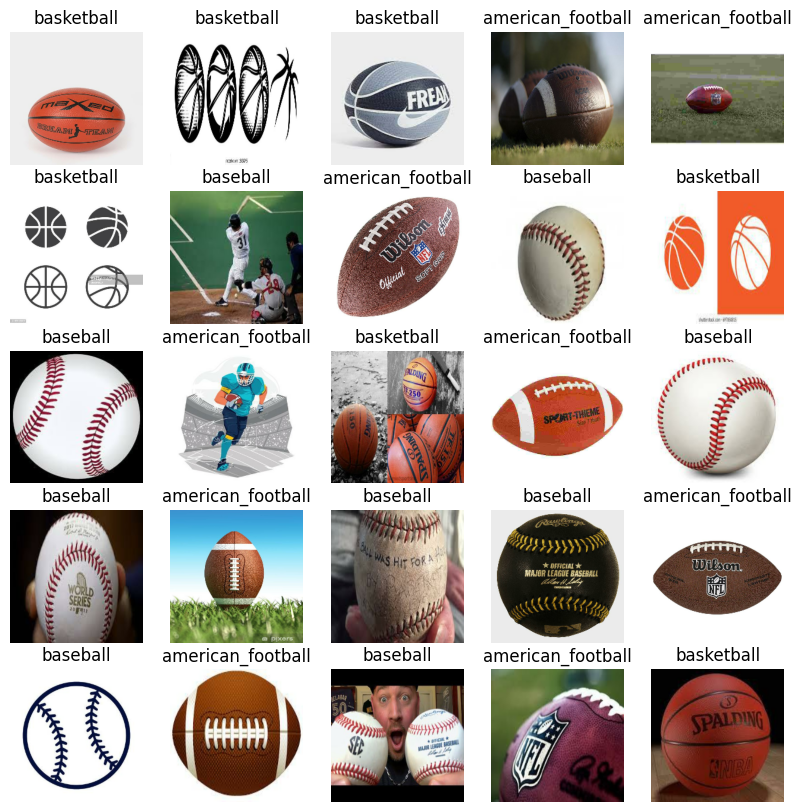

In [14]:
image,label= next(train_data.as_numpy_iterator())
visualize_data(image,label)

In [ ]:
#lets tune our model and show what we can calssify
input_shape= [None, 224 , 224,3]
output_shape=len(unique_labels)
Model_url="https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"
import tf_keras as keras

In [16]:
def create_Model(input_shape=input_shape,output_shape=output_shape,model_url=Model_url):
  print("Creating model")
  model= keras.Sequential([
    hub.KerasLayer(model_url ),
    keras.layers.Dense(units=output_shape,activation="softmax")
  ])
  model.compile(
      loss= keras.losses.CategoricalCrossentropy(),
      optimizer= keras.optimizers.Adam(),
      metrics=["accuracy"]
  )
  model.build(input_shape=input_shape)
  return model


In [17]:
model= create_Model()

Creating model


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 15)                15030     
                                                                 
Total params: 5447743 (20.78 MB)
Trainable params: 15030 (58.71 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________


In [19]:
#lets create the tensorboard"
%load_ext tensorboard


In [20]:
import datetime


def model_tensorboard():
  log_dir= os.path.join("/content/drive/MyDrive/Ball_Game/logs",
                     datetime.datetime.now().strftime("%Y%M%D-%H%m%s")
                        )
  return keras.callbacks.TensorBoard(log_dir=log_dir)
early_callback= keras.callbacks.EarlyStopping(monitor="val_loss",patience=3)

In [21]:

#lets create the Model
NUM_EPOCHS=100 #@param {type:"slider",min:10,max:100,step:10}

In [22]:
#loding the model
def Load_model():
  print("Loading and fitting  the model ")
  model= create_Model()
  model.fit(x=train_data,validation_data=val_data,epochs=NUM_EPOCHS,validation_freq=1,callbacks=[model_tensorboard(),early_callback])
  return model


In [23]:
mdoel= Load_model()

Loading and fitting  the model 
Creating model
Epoch 1/100


KeyboardInterrupt: 

In [ ]:
mdoel.evaluate(train_data)

In [ ]:
predictions= mdoel.predict(val_data,verbose=1)

10/10 [==============================] - 2s 148ms/step


In [ ]:
unique_labels[np.argmax(predictions[0])]

np.str_('american_football')

In [24]:
#creating functions to get the predictions label
def get_pred_label(prediction_probabilities):
  return unique_labels[np.argmax(prediction_probabilities)]

#lets unbatchify data so that we can compare or we can numpy array from tensor values
# def unbatchify(data):
#   images=[]
#   labels=[]
#   for image , label in data.as_numpy_iterator():
#     images.append(image)
#     labels.append(unique_labels[np.argmax(label)])
#   return images,labels


#lets create function to unbatchify the valdata so that we can make predictions
def unbatchify(data):
  images=[]
  labels=[]
  for image,label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_labels[np.argmax(label)])
  return images,labels
# def visualize_predictions(images,labels,predictions,n=1):
#     pred_prob,image,true_label= predictions[n],images[n],labels[n]
#     pred_label= get_pred_label(pred_prob)
#     plt.imshow(image)

#     if true_label == pred_label:
#       color='green'
#     else: color='red'

#     plt.xticks([])
#     plt.yticks([])
#     plt.title(f"pred:{pred_label} truth:{true_label}, Probability :{np.max(pred_prob)*100:.2f}%",color=color)
#     plt.show()
unique_labels=np.array(unique_labels)
def plot_pred(prediction_prob, images,labels,n=1):
  pred_prob,image,truth_label= prediction_prob[n],images[n],labels[n]
  pred_label= get_pred_label(pred_prob)
  plt.imshow(image)
  if pred_label==truth_label:
    color="green"
  else:
    color="red"
  plt.xticks([])
  plt.yticks([])
  plt.title(f"pred:{pred_label} truth:{truth_label}, Probability :{np.max(pred_prob)*100:.2f}%",color=color)
  plt.show()







In [ ]:
val_images,val_labels= unbatchify(val_data)
plot_pred(prediction_prob=predictions,images=val_images,labels=val_labels,n=111)


In [ ]:
#loding the model
create_batches(x=x)

In [3]:
#a function to save the model
def  save_model(model,suffix=None):
  model_dir= os.path.join("/content/drive/MyDrive/Ball_Game/models",
                           datetime.datetime.now().strftime("%Y%M%D-%H%m%s")
                           )
  model_path=model_dir+"_"+suffix+".h5"
  model.save(model_path)
  return model_path

In [4]:
def load_model(model_path):
  print(f"Loading saved model from: {model_path}")
  model= keras.models.load_model(model_path,custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [ ]:
save_model(mdoel,suffix="1000_image_trained")

In [ ]:
model=load_model("/content/drive/MyDrive/Ball_Game/models/20254307/28/25-10071753699412_1000_image_trained.h5")

Loading saved model from: /content/drive/MyDrive/Ball_Game/models/20254307/28/25-10071753699412_1000_image_trained.h5


In [ ]:
model.evaluate(train_data)

22/22 [==============================] - 5s 171ms/step - loss: 0.0200 - accuracy: 1.0000


[0.019953040406107903, 1.0]

In [28]:
#creating batches
full_data=x
full_label=y
full_values= create_batches(x=full_data,y=full_label)

creating_training_data, bathces


In [29]:
full_model= create_Model()

Creating model


In [30]:
full_model_tensorbord= model_tensorboard()
full_model_early_callback= keras.callbacks.EarlyStopping(monitor="loss",patience=3)


In [31]:
full_model.fit(x=full_values,epochs=100,callbacks=[full_model_tensorbord,full_model_early_callback])

Epoch 1/100
229/229 [==============================] - 1283s 5s/step - loss: 1.0073 - accuracy: 0.6981
Epoch 2/100
229/229 [==============================] - 39s 168ms/step - loss: 0.4991 - accuracy: 0.8474
Epoch 3/100
229/229 [==============================] - 41s 177ms/step - loss: 0.3854 - accuracy: 0.8833
Epoch 4/100
229/229 [==============================] - 43s 186ms/step - loss: 0.3252 - accuracy: 0.8985
Epoch 5/100
229/229 [==============================] - 41s 179ms/step - loss: 0.2779 - accuracy: 0.9157
Epoch 6/100
229/229 [==============================] - 40s 174ms/step - loss: 0.2443 - accuracy: 0.9314
Epoch 7/100
229/229 [==============================] - 39s 171ms/step - loss: 0.2162 - accuracy: 0.9338
Epoch 8/100
229/229 [==============================] - 40s 173ms/step - loss: 0.1951 - accuracy: 0.9465
Epoch 9/100
229/229 [==============================] - 40s 176ms/step - loss: 0.1742 - accuracy: 0.9521
Epoch 10/100
229/229 [==============================] - 40s 174ms

In [43]:
save_model(full_model,suffix="fully_image_trained")

/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'/content/drive/MyDrive/Ball_Game/models/20251807/29/25-12071753791496_fully_image_trained.h5'

In [9]:
my_model=load_model("/content/drive/MyDrive/Ball_Game/models/20251807/29/25-12071753791496_fully_image_trained.h5")

Loading saved model from: /content/drive/MyDrive/Ball_Game/models/20251807/29/25-12071753791496_fully_image_trained.h5


In [10]:
my_model.evaluate(train_data)

NameError: name 'train_data' is not defined

In [13]:
import os

In [14]:
test_data= [os.path.join("/content/drive/MyDrive/Ball_Game/test",folder, file)
for folder in  os.listdir("/content/drive/MyDrive/Ball_Game/test")
for file in os.listdir(os.path.join("/content/drive/MyDrive/Ball_Game/test",folder))]

In [20]:
test_tensor_batch= create_batches(test_data,test_data=True)



creating_test_data, bathces


In [27]:
test_tensor_batch
def unbatch(data):
  images=[]
  for image in  data.unbatch().as_numpy_iterator():
    images.append(image)
  return images
images=unbatch(test_tensor_batch)


In [23]:
predictions=my_model.predict(test_tensor_batch)

58/58 [==============================] - 13s 216ms/step


In [30]:
#lets visualize the prepare the  visualization
def test_visualzation(predictions,images, n=1):
  pred_prob,image= predictions[n],images[n]
  pred_label= unique_labels[np.argmax(pred_prob)]
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])
  plt.title(f"pred:{pred_label}")
  plt.show()


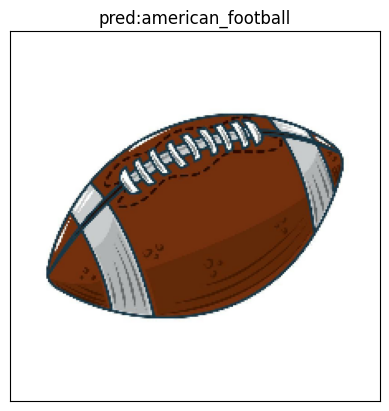

In [35]:
test_visualzation(predictions,images,n=11)